# Train and Host a Keras Sequential Model

This notebook shows how to train and host a Keras Sequential model on SageMaker. The model used for this notebook is a simple deep CNN that was extracted from [the Keras examples](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py).

## The dataset
The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) is one of the most popular machine learning datasets. It consists of 60,000 32x32 images belonging to 10 different classes (6,000 images per class). Here are the classes in the dataset, as well as 10 random images from each:

![cifar10](https://maet3608.github.io/nuts-ml/_images/cifar10.png)

In this tutorial, we will train a deep CNN to recognize these images.

## Set up the environment

In [1]:
import os
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()


## Download the CIFAR-10 dataset
Downloading the test and training data will take around 5 minutes.

In [2]:
import utils

utils.cifar10_download()

## Upload the dataset to an S3 bucket

In [ ]:
inputs = sagemaker_session.upload_data(path='/tmp/cifar10_data', key_prefix='data/DEMO-cifar10')


`sagemaker_session.upload_data` will upload the CIFAR-10 dataset from this machine to a bucket named **sagemaker-{region}-{*your aws account number*}**, if you don't have this bucket yet, `sagemaker_session` will create it for you.

## Complete source code
Here is the full source code for the model:

In [4]:
!cat cifar10_cnn.py

#     Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
#     Licensed under the Apache License, Version 2.0 (the "License").
#     You may not use this file except in compliance with the License.
#     A copy of the License is located at
#    
#         https://aws.amazon.com/apache-2-0/
#    
#     or in the "license" file accompanying this file. This file is distributed
#     on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either
#     express or implied. See the License for the specific language governing
#     permissions and limitations under the License.

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

import tensorflow as tf
from tensorflow.python.keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.python.keras.models import Sequential
from tensorflow.python.saved_model.signature_constants import PREDICT_INPUTS
from tensor

Lets take a closer look:

### The model function
This function constitutes the main difference between TensorFlow and Keras models on SageMaker; Keras models have a `keras_model_fn`:

In [5]:
def keras_model_fn(hyperparameters):
    """keras_model_fn receives hyperparameters from the training job and returns a compiled keras model.
    The model will be transformed into a TensorFlow Estimator before training and it will be saved in a 
    TensorFlow Serving SavedModel at the end of training.

    Args:
        hyperparameters: The hyperparameters passed to the SageMaker TrainingJob that runs your TensorFlow 
                         training script.
    Returns: A compiled Keras model
    """
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', name='inputs', input_shape=(HEIGHT, WIDTH, DEPTH)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES))
    model.add(Activation('softmax'))
    
    opt = RMSPropOptimizer(learning_rate=hyperparameters['learning_rate'], decay=hyperparameters['decay'])

    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

This function builds and returns a compiled Keras model.

**Note:** The first layer is named `PREDICT_INPUTS`. This serves as a workaround for a known issue where TensorFlow does not recognize the default (or any custom) name for the first layer of Keras models. Furthermore, note that we are wrapping our model in a `tf.keras.Model` before returning it. This serves as a workaround for a known issue where a Sequential model cannot be directly converted into an Estimator. See [here](https://github.com/tensorflow/tensorflow/issues/20552) for more information about the issue.

### Input functions
These functions are similar to those required by any other model using the TensorFlow Estimator API.

In [6]:
def serving_input_fn(params):
    # Notice that the input placeholder has the same input shape as the Keras model input
    tensor = tf.placeholder(tf.float32, shape=[None, HEIGHT, WIDTH, DEPTH])
    
    # The inputs key INPUT_TENSOR_NAME matches the Keras InputLayer name
    inputs = {INPUT_TENSOR_NAME: tensor}
    return tf.estimator.export.ServingInputReceiver(inputs, inputs)


def train_input_fn(training_dir, params):
    return _input(tf.estimator.ModeKeys.TRAIN,
                    batch_size=BATCH_SIZE, data_dir=training_dir)


def eval_input_fn(training_dir, params):
    return _input(tf.estimator.ModeKeys.EVAL,
                    batch_size=BATCH_SIZE, data_dir=training_dir)

The `train_` and `eval_` functions call the `_input` function which returns a properly processed and shuffled (for training) set of images and labels.

## Create a training job using the SageMaker TensorFlow Estimator

In [7]:
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(entry_point='cifar10_cnn.py',
                       role=role,
                       framework_version='1.12.0',
                       hyperparameters={'learning_rate': 1e-4, 'decay':1e-6},
                       training_steps=1000, evaluation_steps=100,
                       train_instance_count=1, train_instance_type='ml.c4.xlarge')

estimator.fit(inputs)

tensorflow py2 container will be deprecated soon.


2019-07-17 03:09:43 Starting - Starting the training job...
2019-07-17 03:09:45 Starting - Launching requested ML instances......
2019-07-17 03:10:48 Starting - Preparing the instances for training......
2019-07-17 03:12:11 Downloading - Downloading input data
2019-07-17 03:12:11 Training - Training image download completed. Training in progress..
2019-07-17 03:12:11,350 INFO - root - running container entrypoint
2019-07-17 03:12:11,350 INFO - root - starting train task
2019-07-17 03:12:11,363 INFO - container_support.training - Training starting
2019-07-17 03:12:14,212 INFO - tf_container - ----------------------TF_CONFIG--------------------------
2019-07-17 03:12:14,212 INFO - tf_container - {"environment": "cloud", "cluster": {"master": ["algo-1:2222"]}, "task": {"index": 0, "type": "master"}}
2019-07-17 03:12:14,212 INFO - tf_container - ---------------------------------------------------------
2019-07-17 03:12:14,212 INFO - tf_container - creating RunConfig:
2019-07-17 03:12:14,21

**Note**: Keras models have a known issue and cannot be used for distributed (multi-instance) training. Keep `train_instance_count == 1` until the TensorFlow/Keras team support this feature. See [here](https://github.com/tensorflow/tensorflow/issues/14504) for more information about the issue.


## Deploy the trained model

The deploy() method creates an endpoint which serves prediction requests in real-time.

In [19]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

The Python 2 tensorflow images will be soon deprecated and may not be supported for newer upcoming versions of the tensorflow images.
Please set the argument "py_version='py3'" to use the Python 3 tensorflow image.
Using already existing model: sagemaker-tensorflow-2019-07-17-03-09-42-707


--------------------------------------------------------------------------------------!

## Make some predictions
Prediction is not the focus of this notebook, so to verify the endpoint's functionality, we'll simply generate random data in the correct shape and make a prediction.

In [21]:
# Creating fake prediction data
import numpy as np
data = np.random.randn(1, 32, 32, 3)

# The inputs key 'inputs_input' matches the Keras InputLayer name
predictor.predict({'inputs_input': data}) 

{'outputs': {'activation_5': {'dtype': 1,
   'tensor_shape': {'dim': [{'size': 1}, {'size': 10}]},
   'float_val': [0.008381557650864124,
    0.12379725277423859,
    0.010281337425112724,
    0.03265335410833359,
    0.04084131121635437,
    0.021275771781802177,
    0.21077151596546173,
    0.2393873780965805,
    0.001079387846402824,
    0.3115311563014984]}},
 'model_spec': {'name': 'generic_model',
  'version': {'value': 1563333390},
  'signature_name': 'serving_default'}}

## Download test image

--2019-07-17 19:36:48--  https://upload.wikimedia.org/wikipedia/commons/1/17/Rotkehlchen_bird.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1105749 (1.1M) [image/jpeg]
Saving to: ‘/tmp/test.jpg’

/tmp/test.jpg       100%[===================>]   1.05M  --.-KB/s    in 0.1s    

2019-07-17 19:36:48 (8.25 MB/s) - ‘/tmp/test.jpg’ saved [1105749/1105749]



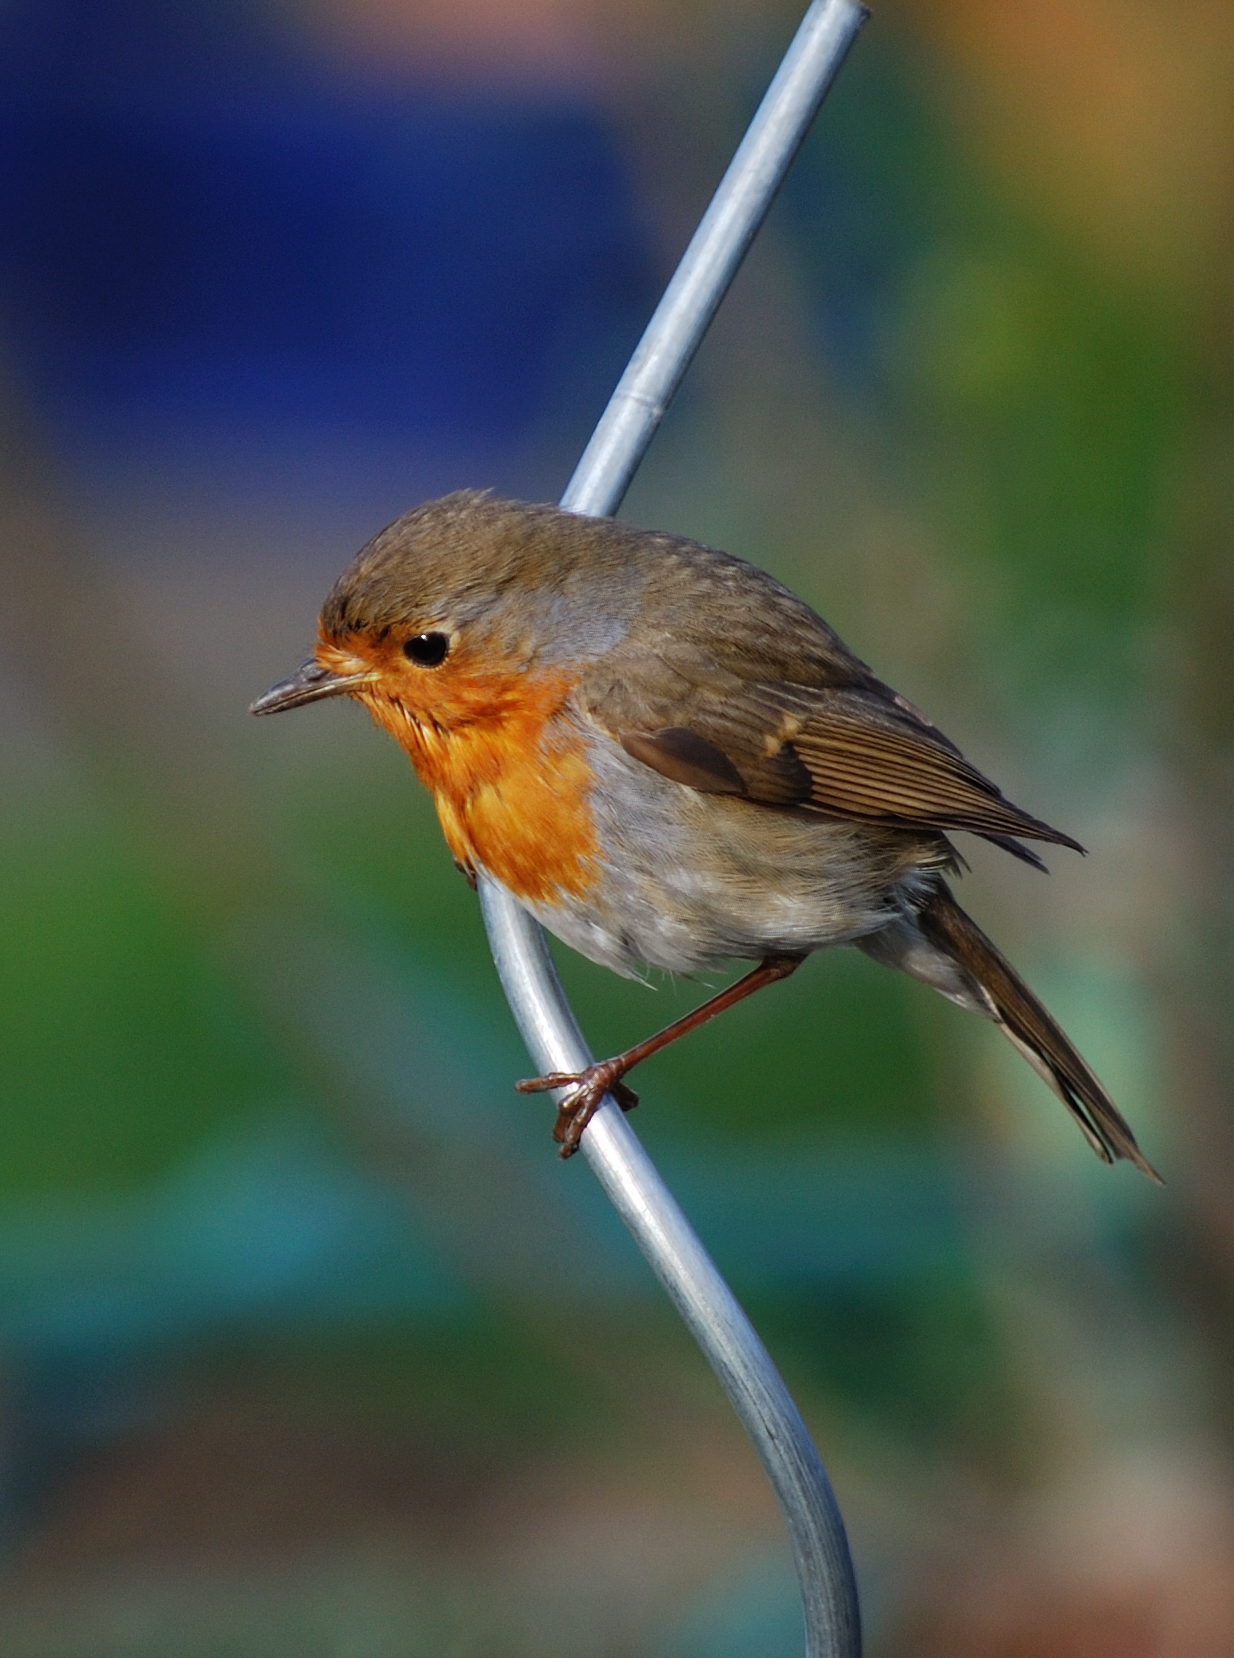

In [47]:
# Bird
!wget -O /tmp/test.jpg https://upload.wikimedia.org/wikipedia/commons/1/17/Rotkehlchen_bird.jpg
file_name = '/tmp/test.jpg'
from IPython.display import Image
Image(file_name)

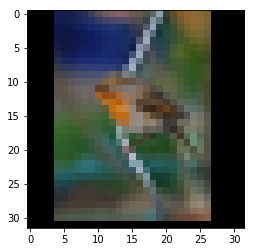

In [48]:
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np

%matplotlib inline

desired_size = 32
im = Image.open(file_name)
old_size = im.size

ratio = float(desired_size)/max(old_size)
new_size = tuple([int(x*ratio) for x in old_size])

new_size

im = im.resize(new_size, Image.ANTIALIAS)
np_im = np.array(im)
np_im.shape

new_im = Image.new("RGB", (desired_size, desired_size))
new_im.paste(im, ((desired_size-new_size[0])//2,
                    (desired_size-new_size[1])//2))

np_new_im = np.array(new_im)
np_new_im.shape

imshow(np_new_im)

# imshow(np_im)
# np_im = np.array(im)
# np_im.shape

# imshow(np_im)


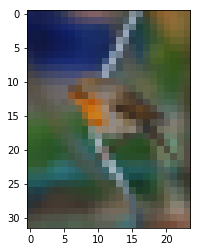

In [32]:
size = 32, 32
im.resize(size, Image.ANTIALIAS)

np_im = np.array(im)
np_im.shape

imshow(np_im)

In [49]:
np_new_im = np_new_im[np.newaxis, ...]
np_new_im.shape

(1, 32, 32, 3)

In [54]:
response = predictor.predict({'inputs_input': np_new_im})
response

{'outputs': {'activation_5': {'dtype': 1,
   'tensor_shape': {'dim': [{'size': 1}, {'size': 10}]},
   'float_val': [0.0,
    0.0,
    0.0,
    1.3651475534918164e-18,
    0.0,
    1.0,
    0.0,
    0.0,
    0.0,
    0.0]}},
 'model_spec': {'name': 'generic_model',
  'version': {'value': 1563333390},
  'signature_name': 'serving_default'}}

In [67]:
import json
from sagemaker.tensorflow import TensorFlowPredictor
predictor = TensorFlowPredictor('sagemaker-tensorflow-2019-07-17-03-09-42-707')
result = predictor.predict({'inputs_input': np_new_im})
predict_class = list(result['outputs'].keys())[0].split("_")[1]
predict_class
# for key in result['outputs']:
#     predict_class = key.split("_")[1]) 

'5'

In [69]:
# 0 : airplane
# 1 : automobile
# 2 : bird
# 3 : cat
# 4 : deer
# 5 : dog
# 6 : frog
# 7 : horse
# 8 : ship
# 9 : truck
object_categories = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(object_categories[int(predict_class)])

dog


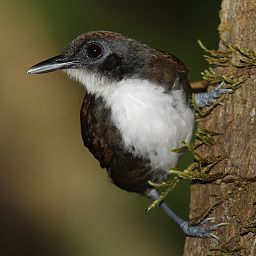

In [70]:
file_name = './bird.jpg'
from IPython.display import Image
Image(file_name)

In [77]:
from PIL import Image
import numpy as np

im = Image.open(file_name)
size = 32, 32
im_resize = im.resize(size, Image.ANTIALIAS)

np_im = np.array(im_resize)
# np_im.shape
# imshow(np_im)
np_new_im = np_im[np.newaxis, ...]
result = predictor.predict({'inputs_input': np_new_im})
predict_class = list(result['outputs'].keys())[0].split("_")[1]
predict_class


'5'

# Cleaning up
To avoid incurring charges to your AWS account for the resources used in this tutorial you need to delete the SageMaker Endpoint:

In [10]:
sagemaker.Session().delete_endpoint(predictor.endpoint)